In [25]:
import pandas as pd
import pandahouse as ph
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from scipy import stats
import seaborn as sns

In [26]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20221020'
}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-10-03' and '2022-10-09'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)
df


,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
...,...,...,...,...,...
20026,1,132567,45,296,0.152027
20027,1,30872,11,59,0.186441
20028,2,25383,42,127,0.330709
20029,2,139020,24,114,0.210526


## Распределене CTR в обеих группах ##

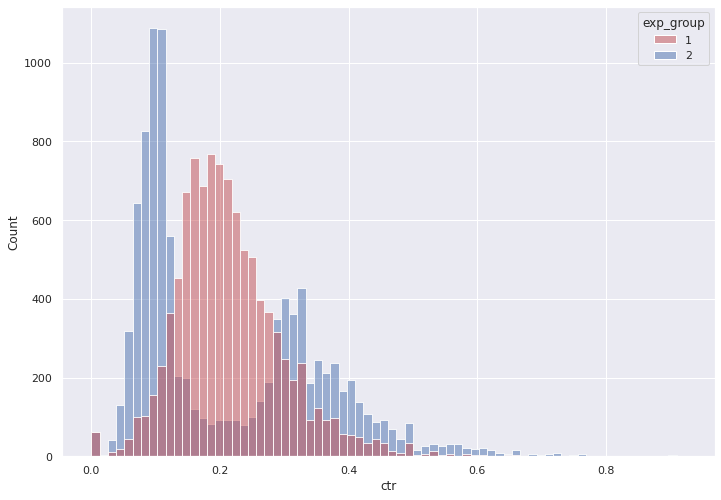

In [39]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Уже можно отметить, что распределение CTR в тестовой группе является **бимодальным**.

## t-критерий Стьюдента ##

In [27]:
# t-критерий Стьюдента
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

Данный тест не дает нам оснований отвергать нулевую гипотезу, однако из-за того, что распределение тестовой группы бимодально, скорее всего t-тест ничего адекватного нам тут не покажет.

## Тест Манна-Уитни ##

In [28]:
#Тест Манна-Уитни
print(stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr))

print('Отличие прокрасилось')

A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)
Отличие прокрасилось
В 56.13 % случаев A > B


Тест Манна-Уитни показал нам, что статистически значимые различия все же есть.

## t-тест на сглаженном ctr (α=5) ##

<AxesSubplot:xlabel='ctr'>

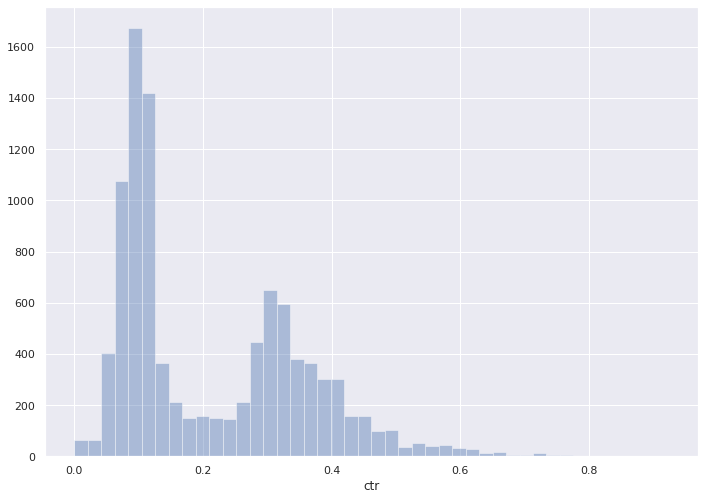

In [44]:
#t-тест на сглаженном ctr (α=5)

def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr


global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()
sns.distplot(group2.ctr, 
             kde = False)



/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='smothed_ctr'>

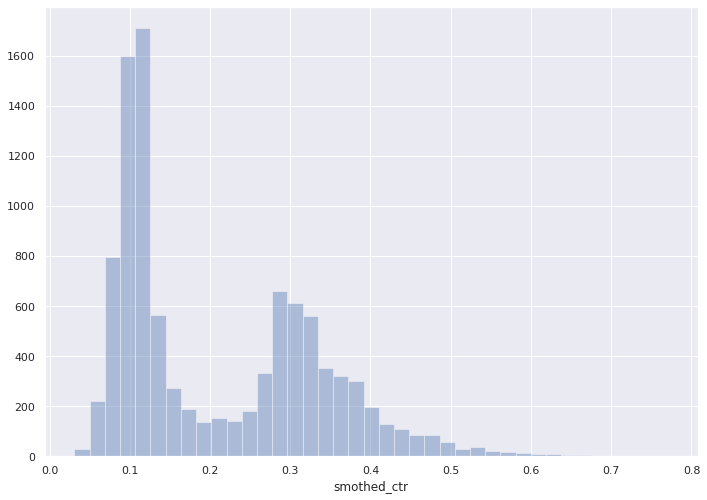

In [43]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.distplot(group2.smothed_ctr, 
             kde = False)

In [32]:
stats.ttest_ind(group1['smothed_ctr'],
                group2['smothed_ctr'],
                equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

t-тест на сглаженном ctr показал нам статистически значимые различия. На самом деле на мой взгляд сглаженный и оригинальный ctr в тестовой группе отличаются не сильно. Не уверена, что принимать во внимание результаты этого теста будет целесообразно, так как все еще нарушаются условия для его проведения.

## Пуассоновский бутстреп ##

<AxesSubplot:ylabel='Count'>

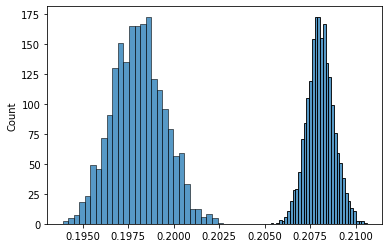

In [33]:
#Пуассоновский бутстреп
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2



likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)


<AxesSubplot:ylabel='Count'>

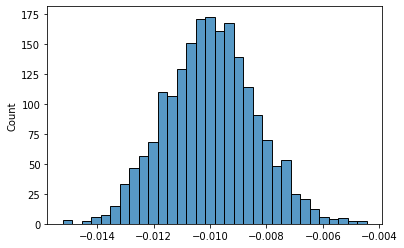

In [34]:
#Разница между глобальными CTR

sns.histplot(ctr2 - ctr1)


Распределение разницы глобальных CTR не пересекает 0, значит отличия являются статистически значимыми, более того глобальный ctr тестовой группы **ниже** чем у контрольной.

## Бакетное преобразование ##

In [35]:
#Бакетное преобразование 
q1 = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-10-03' and '2022-10-09'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df1 = ph.read_clickhouse(q1, connection=connection)

#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df1[df1.exp_group == 1].bucket_ctr, 
                   df1[df1.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [36]:
#и t-тест тоже

stats.ttest_ind(df1[df1.exp_group == 1].bucket_ctr, 
                   df1[df1.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

t-тест и тест Манна-Уитни поверх бакетного преобразования показали статистически значимые отличия.

## Выводы ##

На самом деле получили довольно интересную картину. Получается, что средний CTR сильно просел, плюс у нас появились две моды по обе стороны. То есть возросло количество людей, которые стали ставить лайки реже(первая мода), но при этом есть и вторая мода, где CTR наоборот вырос, а значит люди стали ставить лайки чаще. Возможно такая ситуация получилась из-за того, что часть пользователей ставит лайки на автомате, тем самым наш алгоритм захломляет ленту новостей показывая много однообразного контента, который не так интересен конечному пользователю. И с другой стороны юзеры, которые очень избирательно ставят лайки, тем самым помогая алгоритму подбирать релевантные посты. 
Раскатывать данное обновление все же не стоит, так как оно работает не совсем так как мы хотели бы. Плюс ко всему Пуассоновский бутстрэп показал нам, что новый алгоритм приводит к снижению CTR.
